<h2> Classification of Celeb_A Dataset </h2> 

- Building of pipeline for dataprocessing
- Using Pretrained CNN(Transfer Learning) and parameter tuning 

The Celeb_A dataset contains 202599 images, however we shall use only 50000 images due to performance limitations and speed of training.

Furthermore, for the first time, I have set up Tensorflow to implement both CPU and GPU, with GPU being used during model training to speed up the process.

In [1]:
import numpy as np
import pandas as pd
import re
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
from tensorflow import keras

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


We can see from above that the GPU is being used

In [5]:
image_limit = 50000
dataset_source_path = r'D:\My Stuff\Datasets\Celeb_A\img_align_celeba'

In [6]:
image_list = os.listdir(dataset_source_path)
image_list[0]

'000001.jpg'

In [7]:
labels_path = os.path.join(r'D:\My Stuff\Datasets\Celeb_A',r'list_attr_celeba.txt')
labels_df = pd.read_csv(labels_path, header = [1])
labels_df.head()

,5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young
0,000001.jpg -1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 1...
1,000002.jpg -1 -1 -1 1 -1 -1 -1 1 -1 -1 -1 1...
2,000003.jpg -1 -1 -1 -1 -1 -1 1 -1 -1 -1 1 -1...
3,000004.jpg -1 -1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1...
4,000005.jpg -1 1 1 -1 -1 -1 1 -1 -1 -1 -1 -1...


In [8]:
def prep_label_rows(row):
    row_items = row[0].split()
    row_items[1:] = list(map(int,row_items[1:]))
    return row_items

In [9]:
def prep_labels_dataframe(labels_df):
    columns = labels_df.columns.tolist()[0].split()
    columns.insert(0,'Image')
    list_of_rows = labels_df.to_numpy().tolist()
    list_of_rows = list(map(prep_label_rows,list_of_rows))
    labels_df_dict = {key:list() for key in columns}
    temp = [[labels_df_dict[key].append(lst[i]) for i,key in tuple(zip(range(len(lst)),list(labels_df_dict.keys())))] for lst in list_of_rows]
    return labels_df_dict

In [10]:
df_size = labels_df.shape[0]
df_size

202599

In [11]:
complete_labels_df = pd.DataFrame(data = prep_labels_dataframe(labels_df))
complete_labels_df.head()

,Image,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [12]:
#Only using the first 50000 instances
reduced_labels_df = complete_labels_df.iloc[:50000,:]
reduced_labels_df.shape

(50000, 41)

In [13]:
reduced_labels_df.replace(-1,0,inplace = True)
reduced_labels_df.head()

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,Image,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [14]:
#creating a file path list
image_file_paths = [os.path.join(dataset_source_path,image_list[i]) for i in range(image_limit)]

In [15]:
#add the file paths to a new file path column in the dataframe
reduced_labels_df["FilePath"] = image_file_paths
reduced_labels_df.head()

<ipython-input-15-601fc3b770dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_labels_df["FilePath"] = image_file_paths


,Image,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,FilePath
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,1,1,0,1,0,1,0,0,1,D:\My Stuff\Datasets\Celeb_A\img_align_celeba\...
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,D:\My Stuff\Datasets\Celeb_A\img_align_celeba\...
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,D:\My Stuff\Datasets\Celeb_A\img_align_celeba\...
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,D:\My Stuff\Datasets\Celeb_A\img_align_celeba\...
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,D:\My Stuff\Datasets\Celeb_A\img_align_celeba\...


<h2 style = "text-align:center;"> Classifying Attractive vs Non Attractive Images </h2>

In [16]:
attractive_labels_df = reduced_labels_df.copy()
labels = attractive_labels_df.pop('Attractive')
file_paths = attractive_labels_df.pop('FilePath')

In [17]:
#split the data into train,test,validation sets 
train_set = file_paths[:30000]
train_labels = labels[:30000]
valid_set = file_paths[30000:40000]
valid_labels = labels[30000:40000]
test_set = file_paths[40000:]
test_labels = labels[40000:]

In [18]:
def convert_image_to_pixels(filepath,label):
    image = tf.io.read_file(filepath)
    image_pixels = tf.io.decode_image(image, channels = 3, dtype = tf.float32)
    return image_pixels,label

In [19]:
def create_dataset_as_generator(filepaths,labels):
    for filepath,label in zip(filepaths,labels):
        image_pixels,label = convert_image_to_pixels(filepath,label)
        yield image_pixels,label

In [20]:
#As the .from_tensor_slices method does not allow to specify the output shape and model.fit does not support operations with tensors having unknown ranks, we have to use the .from_generator method instead
""" train_ds = tf.data.Dataset.from_tensor_slices((train_set,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_set,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_set,test_labels)) """

' train_ds = tf.data.Dataset.from_tensor_slices((train_set,train_labels))\nvalid_ds = tf.data.Dataset.from_tensor_slices((valid_set,valid_labels))\ntest_ds = tf.data.Dataset.from_tensor_slices((test_set,test_labels)) '

Reference to below:

- https://github.com/tensorflow/tensorflow/issues/24520#issuecomment-493787420

- https://www.tensorflow.org/guide/data#consuming_python_generators

In [21]:
train_ds = tf.data.Dataset.from_generator(create_dataset_as_generator,args=[train_set,train_labels],output_types=(tf.float32,tf.int64),output_shapes = (tf.TensorShape([218,178,3]),tf.TensorShape(())))

valid_ds = tf.data.Dataset.from_generator(create_dataset_as_generator,args=[valid_set,valid_labels],output_types=(tf.float32,tf.int64),output_shapes = (tf.TensorShape([218,178,3]),tf.TensorShape(())))

test_ds = tf.data.Dataset.from_generator(create_dataset_as_generator,args=[test_set,test_labels],output_types=(tf.float32,tf.int64),output_shapes = (tf.TensorShape([218,178,3]),tf.TensorShape(())))

In [22]:
#.from_generator allows us to do the following in a single operation, hence this is not required anymore 
""" train_ds = train_ds.map(convert_image_to_pixels)
valid_ds = valid_ds.map(convert_image_to_pixels)
test_ds = test_ds.map(convert_image_to_pixels) """

' train_ds = train_ds.map(convert_image_to_pixels)\nvalid_ds = valid_ds.map(convert_image_to_pixels)\ntest_ds = test_ds.map(convert_image_to_pixels) '

In [23]:
import matplotlib.pyplot as plt

(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)


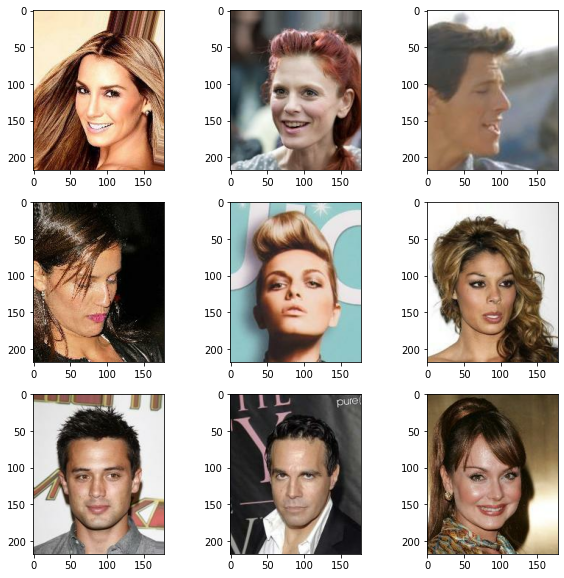

In [24]:
fig,ax = plt.subplots(3,3,figsize = (10,10))
index = 0
i = 0
for image,label in train_ds.take(9):
    print(image.shape)
    ax[index,i].imshow(image)
    if i == 2:
        index += 1
        i = 0
        continue
    i += 1

In [25]:
#making batches of the datasets and shuffling it
train_ds = train_ds.shuffle(1000).repeat()
valid_ds = valid_ds.shuffle(1000).repeat()
test_ds = test_ds.shuffle(1000).repeat()
train_ds = train_ds.batch(32)
valid_ds = valid_ds.batch(32)
test_ds = test_ds.batch(32)

<h3>First we shall build a simple deep neural network to be fit on the dataset</h3>

In [26]:
model_dnn1 = tf.keras.models.Sequential()
model_dnn1.add(tf.keras.layers.Flatten())
#model_dnn1.add(tf.keras.layers.Dense(units = 1000))
#model_dnn1.add(tf.keras.layers.BatchNormalization())
#model_dnn1.add(tf.keras.layers.Activation("elu"))
#model_dnn1.add(tf.keras.layers.Dropout(0.75))
model_dnn1.add(tf.keras.layers.Dense(units = 100))
model_dnn1.add(tf.keras.layers.BatchNormalization())
model_dnn1.add(tf.keras.layers.Activation("elu"))
model_dnn1.add(tf.keras.layers.Dropout(0.75))
model_dnn1.add(tf.keras.layers.Dense(units = 1000))
model_dnn1.add(tf.keras.layers.BatchNormalization())
model_dnn1.add(tf.keras.layers.Activation("elu"))
model_dnn1.add(tf.keras.layers.Dropout(0.5))
model_dnn1.add(tf.keras.layers.Dense(units = 100))
model_dnn1.add(tf.keras.layers.BatchNormalization())
model_dnn1.add(tf.keras.layers.Activation("elu"))
model_dnn1.add(tf.keras.layers.Dropout(0.25))
model_dnn1.add(tf.keras.layers.Dense(units = 10))
model_dnn1.add(tf.keras.layers.BatchNormalization())
model_dnn1.add(tf.keras.layers.Activation("elu"))
model_dnn1.add(tf.keras.layers.Dense(units = 1, activation = "sigmoid"))

In [27]:
precision = keras.metrics.Precision()
accuracy = keras.metrics.BinaryAccuracy()
recall = keras.metrics.Recall()

In [28]:
model_dnn1 = tf.keras.models.load_model(r'D:\My Stuff\Datasets\Celeb_A\model_dnn.h5')

In [29]:
""" model_dnn1.compile(loss = "binary_crossentropy", optimizer="nadam",metrics = [precision,recall,accuracy])
model_dnn1.fit(train_ds,epochs = 15, steps_per_epoch = 938,validation_data=valid_ds,validation_steps=313) """

' model_dnn1.compile(loss = "binary_crossentropy", optimizer="nadam",metrics = [precision,recall,accuracy])\nmodel_dnn1.fit(train_ds,epochs = 15, steps_per_epoch = 938,validation_data=valid_ds,validation_steps=313) '

In [30]:
model_dnn1.evaluate(test_ds, steps = 313)

313/313 [==============================] - 41s 117ms/step - loss: 0.4860 - precision: 0.7514 - recall: 0.8065 - binary_accuracy: 0.7628


[0.4859811067581177,
 0.7514440417289734,
 0.8064703345298767,
 0.7627795338630676]

<h4> The above Deep Neural Network only achieves a binary accuracy of 0.7578 in predicting if an image is attractive or not on the test set</h4>

<h3 style = "text-align:center">Building a ResNet-34 to train the Celeb_A dataset</h3>

I tried to build and train the ResNet-34 model from scratch, however even after using datagenerators to distribute the workload of generating data to the CPU and training to the GPU, the training process was too slow. Hence we shall use a pretrained resnet-50 model from Keras and train its top layer for the CelebA dataset.

In [31]:
#Building a custom ResNet to train the above dataset.
""" from functools import partial

ResidualConv = partial(keras.layers.Conv2D,kernel_size = 3, strides = 1,padding = "SAME", use_bias = False)
class ResidualUnit2(keras.layers.Layer):
    def __init__(self,num_filters,num_strides = 1,activation = "relu",**kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.filters = num_filters
        self.main_layers = [
            ResidualConv(filters = num_filters,strides = num_strides),
            keras.layers.BatchNormalization(),
            self.activation,
            ResidualConv(filters = num_filters),
            keras.layers.BatchNormalization(),
        ]
        self.skip = []
        if(num_strides > 1):
            self.skip = [
                ResidualConv(filters = num_filters,kernel_size = 1, strides = 2),
                keras.layers.BatchNormalization()
            ]
    def call(self,Xvalues):
        Z = Xvalues
        for layer in self.main_layers:
            Z = layer(Z)
        if(len(self.skip)!= 0):
            skip_input = Xvalues
            for layer in self.skip:
                skip_input = layer(skip_input)
            try:
                result = Z + skip_input
            except:
                raise ValueError("Cant Add + skip_input ={} + Z_output={}".format(skip_input.shape,Z_output.shape))
        else:
            result = Z + Xvalues
        return self.activation(result) """

' from functools import partial\n\nResidualConv = partial(keras.layers.Conv2D,kernel_size = 3, strides = 1,padding = "SAME", use_bias = False)\nclass ResidualUnit2(keras.layers.Layer):\n    def __init__(self,num_filters,num_strides = 1,activation = "relu",**kwargs):\n        super().__init__(**kwargs)\n        self.activation = keras.activations.get(activation)\n        self.filters = num_filters\n        self.main_layers = [\n            ResidualConv(filters = num_filters,strides = num_strides),\n            keras.layers.BatchNormalization(),\n            self.activation,\n            ResidualConv(filters = num_filters),\n            keras.layers.BatchNormalization(),\n        ]\n        self.skip = []\n        if(num_strides > 1):\n            self.skip = [\n                ResidualConv(filters = num_filters,kernel_size = 1, strides = 2),\n                keras.layers.BatchNormalization()\n            ]\n    def call(self,Xvalues):\n        Z = Xvalues\n        for layer in self.main

In [32]:
""" model_resnet34 = tf.keras.models.Sequential()
model_resnet34.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=7, strides=1,padding = "SAME"))
model_resnet34.add(tf.keras.layers.BatchNormalization())
model_resnet34.add(tf.keras.layers.Activation("relu"))
model_resnet34.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding = "SAME"))
model_resnet34.add(ResidualUnit2(num_filters=64))
model_resnet34.add(ResidualUnit2(num_filters=64))
model_resnet34.add(ResidualUnit2(num_filters = 128, num_strides=2))
model_resnet34.add(ResidualUnit2(num_filters = 128))
model_resnet34.add(ResidualUnit2(num_filters = 256, num_strides=2))
model_resnet34.add(ResidualUnit2(num_filters = 256))
model_resnet34.add(ResidualUnit2(num_filters = 256))
model_resnet34.add(ResidualUnit2(num_filters = 512, num_strides=2))
model_resnet34.add(ResidualUnit2(num_filters = 512))
model_resnet34.add(ResidualUnit2(num_filters = 512))
model_resnet34.add(tf.keras.layers.GlobalAveragePooling2D())
model_resnet34.add(tf.keras.layers.Flatten())
model_resnet34.add(tf.keras.layers.Dense(1,activation="sigmoid")) """

' model_resnet34 = tf.keras.models.Sequential()\nmodel_resnet34.add(tf.keras.layers.Conv2D(filters = 64, kernel_size=7, strides=1,padding = "SAME"))\nmodel_resnet34.add(tf.keras.layers.BatchNormalization())\nmodel_resnet34.add(tf.keras.layers.Activation("relu"))\nmodel_resnet34.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding = "SAME"))\nmodel_resnet34.add(ResidualUnit2(num_filters=64))\nmodel_resnet34.add(ResidualUnit2(num_filters=64))\nmodel_resnet34.add(ResidualUnit2(num_filters = 128, num_strides=2))\nmodel_resnet34.add(ResidualUnit2(num_filters = 128))\nmodel_resnet34.add(ResidualUnit2(num_filters = 256, num_strides=2))\nmodel_resnet34.add(ResidualUnit2(num_filters = 256))\nmodel_resnet34.add(ResidualUnit2(num_filters = 256))\nmodel_resnet34.add(ResidualUnit2(num_filters = 512, num_strides=2))\nmodel_resnet34.add(ResidualUnit2(num_filters = 512))\nmodel_resnet34.add(ResidualUnit2(num_filters = 512))\nmodel_resnet34.add(tf.keras.layers.GlobalAveragePooling2D())\nmodel_re

<h3>GlobalAveragePooling2D</h3>

input_shape = (batch_size,rows,cols,channels)

output_shape = (batch_size,channels)

In [33]:
precision_resnet34 = keras.metrics.Precision()
accuracy_resnet34 = keras.metrics.BinaryAccuracy()
recall_resnet34 = keras.metrics.Recall()

<h3> Unused but knowledge applies </h3> 

Due to the entire dataset being loaded at once, when using the typical fit methods, we need to use a data generator, which loads data at the end of each epoch. Furthermore using a data generator allows to distribute the data generation to the CPU, while the forward and backward propogation calculations to the GPU.

In [34]:
#create a dictionary of the file paths for training, validation
train_set = file_paths[:20000]
train_labels = labels[:20000]
valid_set = file_paths[20000:30000]
valid_labels = labels[20000:30000]
partition = {'train':[filepath for filepath in train_set],'validation':[filepath for filepath in valid_set]}
labels_gen = {filepath:label for filepath,label in zip(file_paths[:30000],labels[:30000])}

In [35]:
import my_classes

In [36]:
training_generator = my_classes.DataGenerator_custom(partition['train'],labels_gen)
validation_generator = my_classes.DataGenerator_custom(partition['validation'],labels_gen)

In [37]:
""" os.environ["CUDA_VISIBLE_DEVICES"] = "0"
model_resnet34.compile(loss = "binary_crossentropy", optimizer="nadam",metrics = [precision_resnet34,recall_resnet34,accuracy_resnet34])

model_resnet34.fit_generator(generator=training_generator, validation_data=validation_generator,epochs=10, use_multiprocessing=True, workers = 6) """

' os.environ["CUDA_VISIBLE_DEVICES"] = "0"\nmodel_resnet34.compile(loss = "binary_crossentropy", optimizer="nadam",metrics = [precision_resnet34,recall_resnet34,accuracy_resnet34])\n\nmodel_resnet34.fit_generator(generator=training_generator, validation_data=validation_generator,epochs=10, use_multiprocessing=True, workers = 6) '

In [38]:
resnet_50 = keras.applications.ResNet50(weights = "imagenet", include_top = False,input_shape=(224,224,3))

In [39]:
#add averaging pooling layer
avg = tf.keras.layers.GlobalAveragePooling2D()(resnet_50.output)
output = tf.keras.layers.Dense(units = 1, activation = "sigmoid")(avg)
model_resnet50 = keras.models.Model(inputs = resnet_50.input,outputs = output)

In [40]:
for layer in resnet_50.layers:
    layer.trainable = False

In [41]:
optimizer_pre = tf.keras.optimizers.Nadam(learning_rate=0.2)
model_resnet50.compile(loss = "binary_crossentropy", optimizer = optimizer_pre, metrics = [precision_resnet34,recall_resnet34,accuracy_resnet34])

In [42]:
resize_model = tf.keras.models.Sequential()
resize_model.add(tf.keras.layers.experimental.preprocessing.Resizing(height=224, width=224))

def convert_image_to_pixels_resnet(filepath,labels):
    image = tf.io.read_file(filepath)
    image_pixels = tf.io.decode_image(image, channels = 3, dtype = tf.float32)
    image_pixels = resize_model(image_pixels)
    return image_pixels,labels
    

def create_dataset_as_generator_resnet(filepaths,labels):
    for filepath,label in zip(filepaths,labels):
        image_pixels,label = convert_image_to_pixels_resnet(filepath,label)
        yield image_pixels,label

In [43]:
train_ds_resnet = tf.data.Dataset.from_generator(create_dataset_as_generator_resnet,args=[train_set,train_labels],output_types=(tf.float32,tf.int64),output_shapes = (tf.TensorShape([224,224,3]),tf.TensorShape(())))

valid_ds_resnet = tf.data.Dataset.from_generator(create_dataset_as_generator_resnet,args=[valid_set,valid_labels],output_types=(tf.float32,tf.int64),output_shapes = (tf.TensorShape([224,224,3]),tf.TensorShape(())))

test_ds_resnet = tf.data.Dataset.from_generator(create_dataset_as_generator_resnet,args=[test_set,test_labels],output_types=(tf.float32,tf.int64),output_shapes = (tf.TensorShape([224,224,3]),tf.TensorShape(())))

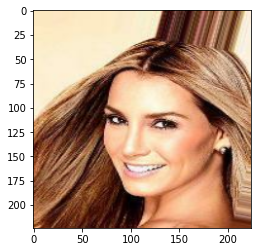

In [44]:
for image,label in train_ds_resnet.take(1):
    plt.imshow(image)

<h3> Image has been modified to fit the resnet-50 neural network</h3>

In [45]:
#making batches of the datasets and shuffling it
train_ds_resnet = train_ds_resnet.shuffle(1000).repeat()
valid_ds_resnet = valid_ds_resnet.shuffle(1000).repeat()
test_ds_resnet = test_ds_resnet.shuffle(1000).repeat()
train_ds_resnet = train_ds_resnet.batch(32)
valid_ds_resnet = valid_ds_resnet.batch(32)
test_ds_resnet = test_ds_resnet.batch(32)

In [46]:
""" model_resnet50.fit(train_ds_resnet, steps_per_epoch = 938, validation_data=valid_ds_resnet,validation_steps = 313, epochs = 5) """

' model_resnet50.fit(train_ds_resnet, steps_per_epoch = 938, validation_data=valid_ds_resnet,validation_steps = 313, epochs = 5) '

In [47]:
#model_resnet50.save(r'D:\My Stuff\Datasets\Celeb_A\resnet50.h5')
model_resnet50 = tf.keras.models.load_model(r'D:\My Stuff\Datasets\Celeb_A\resnet50.h5')

In [48]:

model_resnet50.evaluate(test_ds_resnet,steps = 313)

313/313 [==============================] - 120s 352ms/step - loss: 4.4446 - precision_1: 0.5303 - recall_1: 0.9932 - binary_accuracy: 0.5426


[4.44461727142334, 0.5302748680114746, 0.9932262301445007, 0.5426318049430847]

In [49]:
resize_model_28 = tf.keras.models.Sequential()
resize_model_28.add(tf.keras.layers.experimental.preprocessing.Resizing(height=28, width=28))

def convert_image_to_pixels_resnet_28(filepath,labels):
    image = tf.io.read_file(filepath)
    image_pixels = tf.io.decode_image(image, channels = 3, dtype = tf.float32)
    image_pixels = resize_model_28(image_pixels)
    return image_pixels,labels
    

def create_dataset_as_generator_resnet_28(filepaths,labels):
    for filepath,label in zip(filepaths,labels):
        image_pixels,label = convert_image_to_pixels_resnet_28(filepath,label)
        yield image_pixels,label

In [50]:
train_ds_resnet_28 = tf.data.Dataset.from_generator(create_dataset_as_generator_resnet_28,args=[train_set,train_labels],output_types=(tf.float32,tf.int64),output_shapes = (tf.TensorShape([28,28,3]),tf.TensorShape(())))

valid_ds_resnet_28 = tf.data.Dataset.from_generator(create_dataset_as_generator_resnet_28,args=[valid_set,valid_labels],output_types=(tf.float32,tf.int64),output_shapes = (tf.TensorShape([28,28,3]),tf.TensorShape(())))

test_ds_resnet_28 = tf.data.Dataset.from_generator(create_dataset_as_generator_resnet_28,args=[test_set,test_labels],output_types=(tf.float32,tf.int64),output_shapes = (tf.TensorShape([28,28,3]),tf.TensorShape(())))

In [51]:
model_resnet50_28 = tf.keras.models.clone_model(model_resnet50)

In [52]:
model_resnet50_28.layers[0] = tf.keras.layers.InputLayer(input_shape = (28,28,3 ))

In [53]:
model_resnet50_28.layers[0].input_shape

[(None, 224, 224, 3)]

In [54]:
model_resnet50_28.layers[0]._batch_input_shape

(None, 224, 224, 3)

In [55]:
resnet_50_28 = keras.applications.ResNet50(weights = "imagenet", include_top = False,input_shape=(224,224,3))

In [56]:
#change model to adjust input shape of (28,28)
def change_model(model, new_input_shape = (None,28,28,3)):
    model.layers[0]._batch_input_shape = new_input_shape
    #As we changed the layer weights shape, the model is yet to register that shape has changed, hence we convert the model to json, and load a new model
    new_model = keras.models.model_from_json(model.to_json())
    for layer in new_model.layers:
        try:
            layer.set_weights(model.get_layer(name = layer.name).get_weights())
            print("Loaded layer {}".format(layer.name))
        except:
            print("Could not transfer weights for {}".format(layer.name))
    return new_model

In [57]:
resnet_50_28 = change_model(resnet_50_28)

C:\Users\ASUS\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Loaded layer input_3
Loaded layer conv1_pad
Loaded layer conv1_conv
Loaded layer conv1_bn
Loaded layer conv1_relu
Loaded layer pool1_pad
Loaded layer pool1_pool
Loaded layer conv2_block1_1_conv
Loaded layer conv2_block1_1_bn
Loaded layer conv2_block1_1_relu
Loaded layer conv2_block1_2_conv
Loaded layer conv2_block1_2_bn
Loaded layer conv2_block1_2_relu
Loaded layer conv2_block1_0_conv
Loaded layer conv2_block1_3_conv
Loaded layer conv2_block1_0_bn
Loaded layer conv2_block1_3_bn
Loaded layer conv2_block1_add
Loaded layer conv2_block1_out
Loaded layer conv2_block2_1_conv
Loaded layer conv2_block2_1_bn
Loaded layer conv2_block2_1_relu
Loaded layer conv2_block2_2_conv
Loaded layer conv2_block2_2_bn
Loaded layer conv2_block2_2_relu
Loaded layer conv2_block2_3_conv
Loaded layer conv2_block2_3_bn
Loaded layer conv2_block2_add
Loaded layer conv2_block2_out
Loaded layer conv2_block3_1_conv
Loaded layer conv2_block3_1_bn
Loaded layer conv2_block3_1_relu
Loaded layer conv2_block3_2_conv
Loaded la

In [58]:
#add pooling layer
avg = tf.keras.layers.GlobalAveragePooling2D()(resnet_50_28.output)
output = tf.keras.layers.Dense(units = 1, activation = "sigmoid")(avg)
model_resnet50_28 = keras.models.Model(inputs = resnet_50_28.input,outputs = output)

In [59]:
for layer in resnet_50_28.layers:
    layer.trainable = False

precision_resnet50_28 = keras.metrics.Precision()
accuracy_resnet50_28 = keras.metrics.BinaryAccuracy()
recall_resnet50_28 = keras.metrics.Recall()

nadam_50_28 = tf.keras.optimizers.Nadam(learning_rate=0.2)
model_resnet50_28.compile(loss = "binary_crossentropy", optimizer = nadam_50_28, metrics = [precision_resnet50_28,recall_resnet50_28,accuracy_resnet50_28])

In [60]:
train_ds_resnet_28 = train_ds_resnet_28.shuffle(1000).repeat()
valid_ds_resnet_28 = valid_ds_resnet_28.shuffle(1000).repeat()
test_ds_resnet_28 = test_ds_resnet_28.shuffle(1000).repeat()
train_ds_resnet_28 = train_ds_resnet_28.batch(32)
valid_ds_resnet_28 = valid_ds_resnet_28.batch(32)
test_ds_resnet_28 = test_ds_resnet_28.batch(32)

In [61]:
print("GPU Number :{}".format(len(tf.config.list_physical_devices("GPU"))))

GPU Number :1


In [62]:
model_resnet50_28.fit(train_ds_resnet_28, steps_per_epoch = 938, validation_data=valid_ds_resnet_28,validation_steps = 313, epochs = 5)

Epoch 1/5
938/938 [==============================] - 231s 232ms/step - loss: 4.6703 - precision_2: 0.5623 - recall_2: 0.5632 - binary_accuracy: 0.5519 - val_loss: 3.4219 - val_precision_2: 0.7797 - val_recall_2: 0.2337 - val_binary_accuracy: 0.5733
Epoch 2/5
938/938 [==============================] - 172s 184ms/step - loss: 4.0519 - precision_2: 0.5850 - recall_2: 0.5843 - binary_accuracy: 0.5732 - val_loss: 3.3806 - val_precision_2: 0.5449 - val_recall_2: 0.9720 - val_binary_accuracy: 0.5692
Epoch 3/5
938/938 [==============================] - 174s 186ms/step - loss: 3.6584 - precision_2: 0.5871 - recall_2: 0.5870 - binary_accuracy: 0.5764 - val_loss: 1.9136 - val_precision_2: 0.6076 - val_recall_2: 0.8697 - val_binary_accuracy: 0.6452
Epoch 4/5
938/938 [==============================] - 168s 180ms/step - loss: 3.3313 - precision_2: 0.5924 - recall_2: 0.5924 - binary_accuracy: 0.5813 - val_loss: 1.3680 - val_precision_2: 0.6872 - val_recall_2: 0.6606 - val_binary_accuracy: 0.6716
Epoc

In [63]:
#training the rest of the layers
for layer in resnet_50_28.layers:
    layer.trainable = True

In [64]:
nadam_50_28 = tf.keras.optimizers.Nadam(learning_rate=0.01)
model_resnet50_28.compile(loss = "binary_crossentropy", optimizer = nadam_50_28, metrics = [precision_resnet50_28,recall_resnet50_28,accuracy_resnet50_28])
model_resnet50_28.fit(train_ds_resnet_28, steps_per_epoch = 938, validation_data=valid_ds_resnet_28,validation_steps = 313, epochs = 10)

Epoch 1/10
938/938 [==============================] - 377s 371ms/step - loss: 2.9656 - precision_2: 0.5331 - recall_2: 0.7736 - binary_accuracy: 0.5372 - val_loss: 0.7026 - val_precision_2: 0.5130 - val_recall_2: 0.9998 - val_binary_accuracy: 0.5130
Epoch 2/10
938/938 [==============================] - 362s 386ms/step - loss: 1.5130 - precision_2: 0.5149 - recall_2: 0.9389 - binary_accuracy: 0.5134 - val_loss: 14.4239 - val_precision_2: 0.5135 - val_recall_2: 0.9840 - val_binary_accuracy: 0.5139
Epoch 3/10
938/938 [==============================] - 399s 426ms/step - loss: 1.5675 - precision_2: 0.5126 - recall_2: 0.8972 - binary_accuracy: 0.5092 - val_loss: 0.6933 - val_precision_2: 0.5129 - val_recall_2: 1.0000 - val_binary_accuracy: 0.5129
Epoch 4/10
938/938 [==============================] - 369s 394ms/step - loss: 1.2889 - precision_2: 0.5145 - recall_2: 0.9264 - binary_accuracy: 0.5141 - val_loss: 632.0845 - val_precision_2: 0.5134 - val_recall_2: 1.0000 - val_binary_accuracy: 0.51

In [65]:
model_resnet50_28.save(r'D:\My Stuff\Datasets\Celeb_A\resnet50_28.h5')

C:\Users\ASUS\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [85]:
def box_corner_to_center(boxes):
    #upper_left
    x1 = boxes[0]
    y1 = boxes[1]
    #bottom_right
    x2 = boxes[2]
    y2 = boxes[3]
    centerx = (x1 + x2)/2
    centery = (y1 + y2)/2
    width = abs(x1 - x2)
    height = abs(y1 - y2)
    boxes = tf.stack((centerx,centery,width,height),axis = -1)
    return boxes
    

In [101]:
def box_center_to_corner(boxes):
    centerx = boxes[0]
    centery = boxes[1]
    width = boxes[2]
    height = boxes[3]
    #center to upper_left
    x1 = centerx - (width/2)
    y1 = centery - (height/2)
    #center to bottom_right
    x2 = centerx + width/2
    y2 = centery + (height/2)
    boxes = tf.stack((x1,y1,x2,y2),axis = -1)
    return boxes
    


In [107]:
 box1,box2 = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [108]:
boxes = tf.constant((box1,box2))
boxes

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 60.,  45., 378., 516.],
       [400., 112., 655., 493.]], dtype=float32)>

In [109]:
center = tf.map_fn(box_corner_to_center,elems = boxes)

In [110]:
center

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[219. , 280.5, 318. , 471. ],
       [527.5, 302.5, 255. , 381. ]], dtype=float32)>

In [111]:
corners = tf.map_fn(box_center_to_corner,elems = center)
corners

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[ 60.,  45., 378., 516.],
       [400., 112., 655., 493.]], dtype=float32)>